<hr style="border: solid 3px blue;">

# Introduction

Notebook from https://www.kaggle.com/code/lonelvino/funsd-analyse-dataset

In this notebook, we try to analyze the FUNSD dataset (a dataset  Form Understanding in Noisy Scanned Documents), which contains 199 fully annotated forms that vary widely w.r.t their structure and appearance. The forms come from different fields, *e.g.*, marketing, advertising and scientific reports. They are all one-page forms rendered in a rasterized format with low resolution and corrupted by real noise.

### Dataset Strcuture and Format

Each form is scanned as an image and stored in `training_data/images`, the content of each form is also encoded in a JSON file and stored in `trainig_data/annotations`.

A form is represented as a list of semantic entities that are interlinked. A **semantic entity** represents a group of **words** that belong together from a semantic and spatial standpoint. Each Semantic entity is describled by:

- A bounding box -- `box` ($[x_\textbf{left},  y_\textbf{top}, x_\textbf{right}, y_\textbf{bottom}]$);
- Its textual content -- `text`;
- Its category -- `label` (*i.e.,* `question`, `answer`, `header` or `other`);
- A list of words - `words`, each word is represented by its textual content (`text`) and its bounding box (`box`).
- A list of links with other entities -- `linking` ($[\textbf{id}_\text{from}, \textbf{id}_\text{to}]$);
- A unique identifier -- `id`;

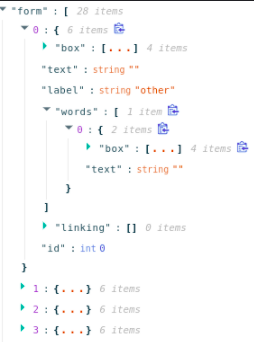

And the data statictis and the semantic entity class distribution are shown as below:

| Split    | Forms | Words | Entites | Relations |
| -------- | ----- | ----- | ------- | --------- |
| Training | 149   | 22512 | 7411    | 4236      |
| Testing  | 50    | 8973  | 2332    | 1076      |


| Split    | Header | Question | Answer | Other | Total |
| -------- | ------ | -------- | ------ | ----- | ----- |
| Training | 441    | 3266     | 2802   | 902   | 7411  |
| Testing  | 122    | 1077     | 821    | 312   | 2332  |
 

---------------------------------------------------------------------
# 1.Setting Up

In [29]:
import os
import glob
import json
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import cv2

import warnings
warnings.filterwarnings('ignore')

In [30]:
plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
plt.rc('axes', labelsize='xx-large', titlesize='xx-large')
plt.rc('legend',fontsize=16)
%matplotlib inline

### Constants

In [31]:
RED = [0, 0, 225]
GREEN = [0,255, 0]
BLUE = [255,0, 0]
CYAN = [255, 255, 0]
label_to_color = {"question": RED, "answer": GREEN, "header": BLUE, "other": CYAN}

## 1.1 Preliminary

### 1.1.1 [Function] Load Images

In [32]:
def load_images(img_path, annotations):
    imgs_org = []; imgs_colored = []
    for idx, image_file in tqdm(enumerate(img_path)):
        imgs_org.append(cv2.imread(image_file))
        imgs_colored.append(color_image(cv2.imread(image_file), annotations[idx]))
    return imgs_org, imgs_colored    

### 1.1.2 [Function] Load Annotations

In [33]:
def load_annotations(annotations_name):
    annotations = []
    for path in tqdm(annotations_name):
        with open(path) as fp:
            annotations.append(Form(json.loads(fp.read())["form"]))
    return annotations

### 1.1.3 [Class] Parse Annotations of a Form

> We can use `*` to unpack the list so that all elements of it can be passed as different parameters. <br>
> And use `**` for dictionaries, passed the items in the dictionary as keyword arguments to the function.

In [34]:
class Box():
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin, self.ymin, self.xmax, self.ymax = xmin, ymin, xmax, ymax
     
    def __repr__(self):
        return f"Box(xmin={self.xmin},ymin={self.ymin}, xmax={self.xmax}, ymax={self.ymax})"

class Word:
    def __init__(self, box, text):
        self.box = Box(*box)
        self.text = text
        
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Word(box={self.box}, text={self.text})"
        
    
class Entity:
    def __init__(self,box, text, label, words, linking, id):
        self.id_ = id
        self.box = Box(*box)
        self.text = text
        self.label = label
        self.words = [ Word(**word) for word in words ] 
        self.linking = linking
    
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Entity(id_={self.id_}, box={self.box}, text={self.text}, label={self.label}, words={self.words}, linking={self.linking})"
    
class Form():
    def __init__(self, entities):
        self.entities = [Entity(**entity) for entity in entities]
        
    def __repr__(self):
        return f"Form(entities={self.entities})"

### 1.1.4 [Function] Color an image

In [35]:
def color_image(image, annotation):
    for entity in annotation.entities:
        box = entity.box
        image_crop = image[box.ymin:box.ymax, box.xmin:box.xmax, :]
        image_crop[np.where((image_crop < [127,127,127]).all(axis = 2))] = label_to_color[entity.label]
        image[box.ymin:box.ymax, box.xmin:box.xmax, :] = image_crop
        
    return image

### 1.1.5 [Function] Display Nultiple Images

In [36]:
import math
import random 
def disp_multi_images(images, suptitle=''):
    len_images = len(images) if len(images)<=25 else 25
    num = math.ceil(math.sqrt(len_images))
    idxs = random.sample(range(0, len(images)), len_images)
    
    fig = plt.figure(figsize=(num**3,num**3)) if num > 3 else  plt.figure(figsize=((num+1)**3,(num+1)**3))
    plt.suptitle(suptitle, size=16, y=3)
    
    for count, index in enumerate(idxs):
        ax = fig.add_subplot(num, num, count + 1, xticks=[], yticks=[])
        image = images[index]
        ax.imshow(image)
        
        if count==len_images-1:
            plt.show()
            break    

## 1.2 Dataset Analyse

### 1.2.1 Load Data

In [37]:
BASE_FOLDER='../data/raw/FUNSD/'

train_path = os.path.join(BASE_FOLDER, "training_data")
test_path = os.path.join(BASE_FOLDER, "testing_data")

train_images_path = sorted(glob.glob("{}/images/*".format(train_path)))
test_images_path = sorted(glob.glob("{}/images/*".format(test_path)))
train_annotations_path = sorted(glob.glob("{}/annotations/*".format(train_path)))
test_annotations_path = sorted(glob.glob("{}/annotations/*".format(test_path)))

print("Total Train images={}. Total Train annotations={}.".format(len(train_images_path), len(train_annotations_path)))
print("Total Test images={}. Total Test annotations={}.".format(len(test_images_path), len(test_annotations_path)))

Total Train images=149. Total Train annotations=149.
Total Test images=50. Total Test annotations=50.


In [38]:
ann_train = load_annotations(train_annotations_path)
img_train_org, img_train_colored = load_images(train_images_path, ann_train)
ann_test = load_annotations(test_annotations_path)
img_test_org, img_test_colored = load_images(test_images_path, ann_test)

  0%|          | 0/149 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

### 1.2.2 Structure and Format

In [39]:
from copy import copy

num_train = {"forms": len(ann_train), "words": 0, "entities":0, \
             "question": 0, "header": 0, "answer": 0, "other": 0}
num_test = copy(num_train); num_test['forms'] = len(ann_test)
for annotation in ann_train:
    num_train["entities"] += len(annotation.entities)
    for entity in annotation.entities:
        num_train[entity.label] += 1
        num_train['words'] += len(entity.words)

for annotation in ann_test:
    num_test["entities"] += len(annotation.entities)
    for entity in annotation.entities:
        num_test[entity.label] += 1
        num_test['words'] += len(entity.words)

In [40]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
            dict_3[key] = [value , dict_1[key]]
    return dict_3

num_label = mergeDictionary(num_train, num_test)
print(pd.DataFrame(num_label, index=['Training', 'Testing']))


          forms  words  entities  question  header  answer  other
Training     50   8973      2332      1077     122     821    312
Testing     149  22512      7411      3266     441    2802    902


### 1.2.3 Visualize images and Check the Similarities

Text(0.5, 1.0, 'Colored Image')

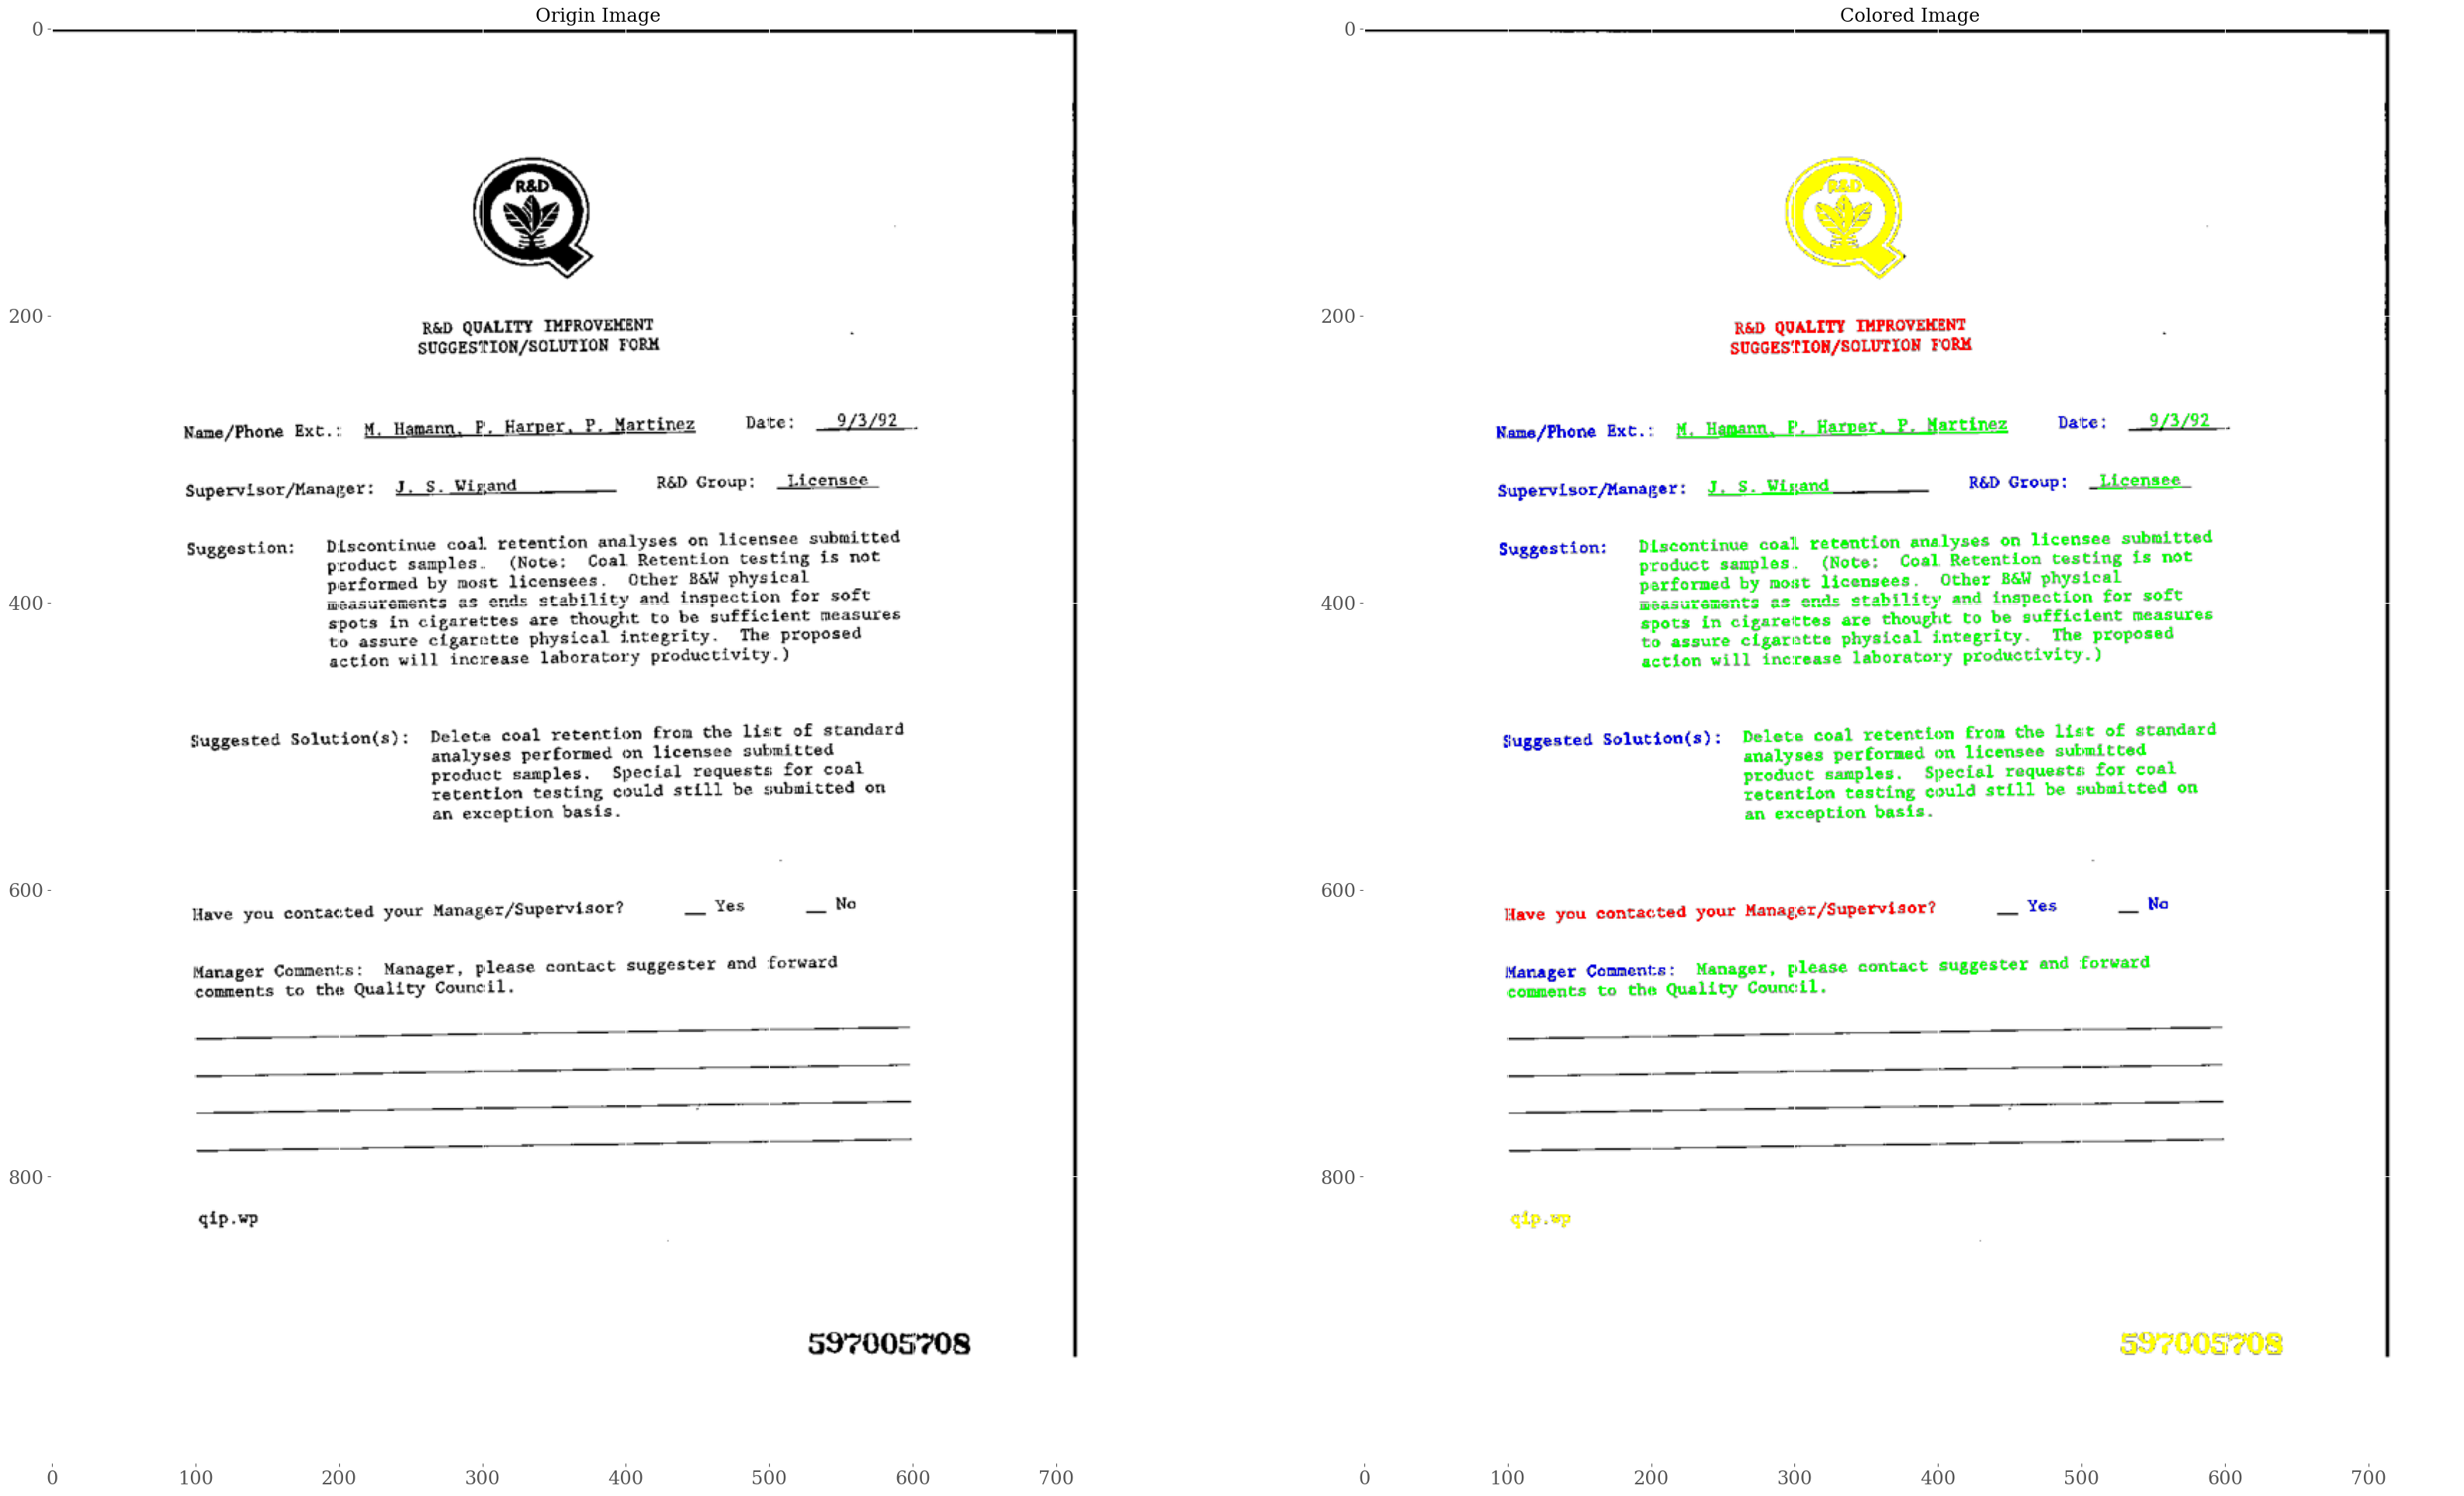

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
axes[0].imshow(img_train_org[0])
axes[0].set_title('Origin Image')
axes[1].imshow(img_train_colored[0])
axes[1].set_title('Colored Image')

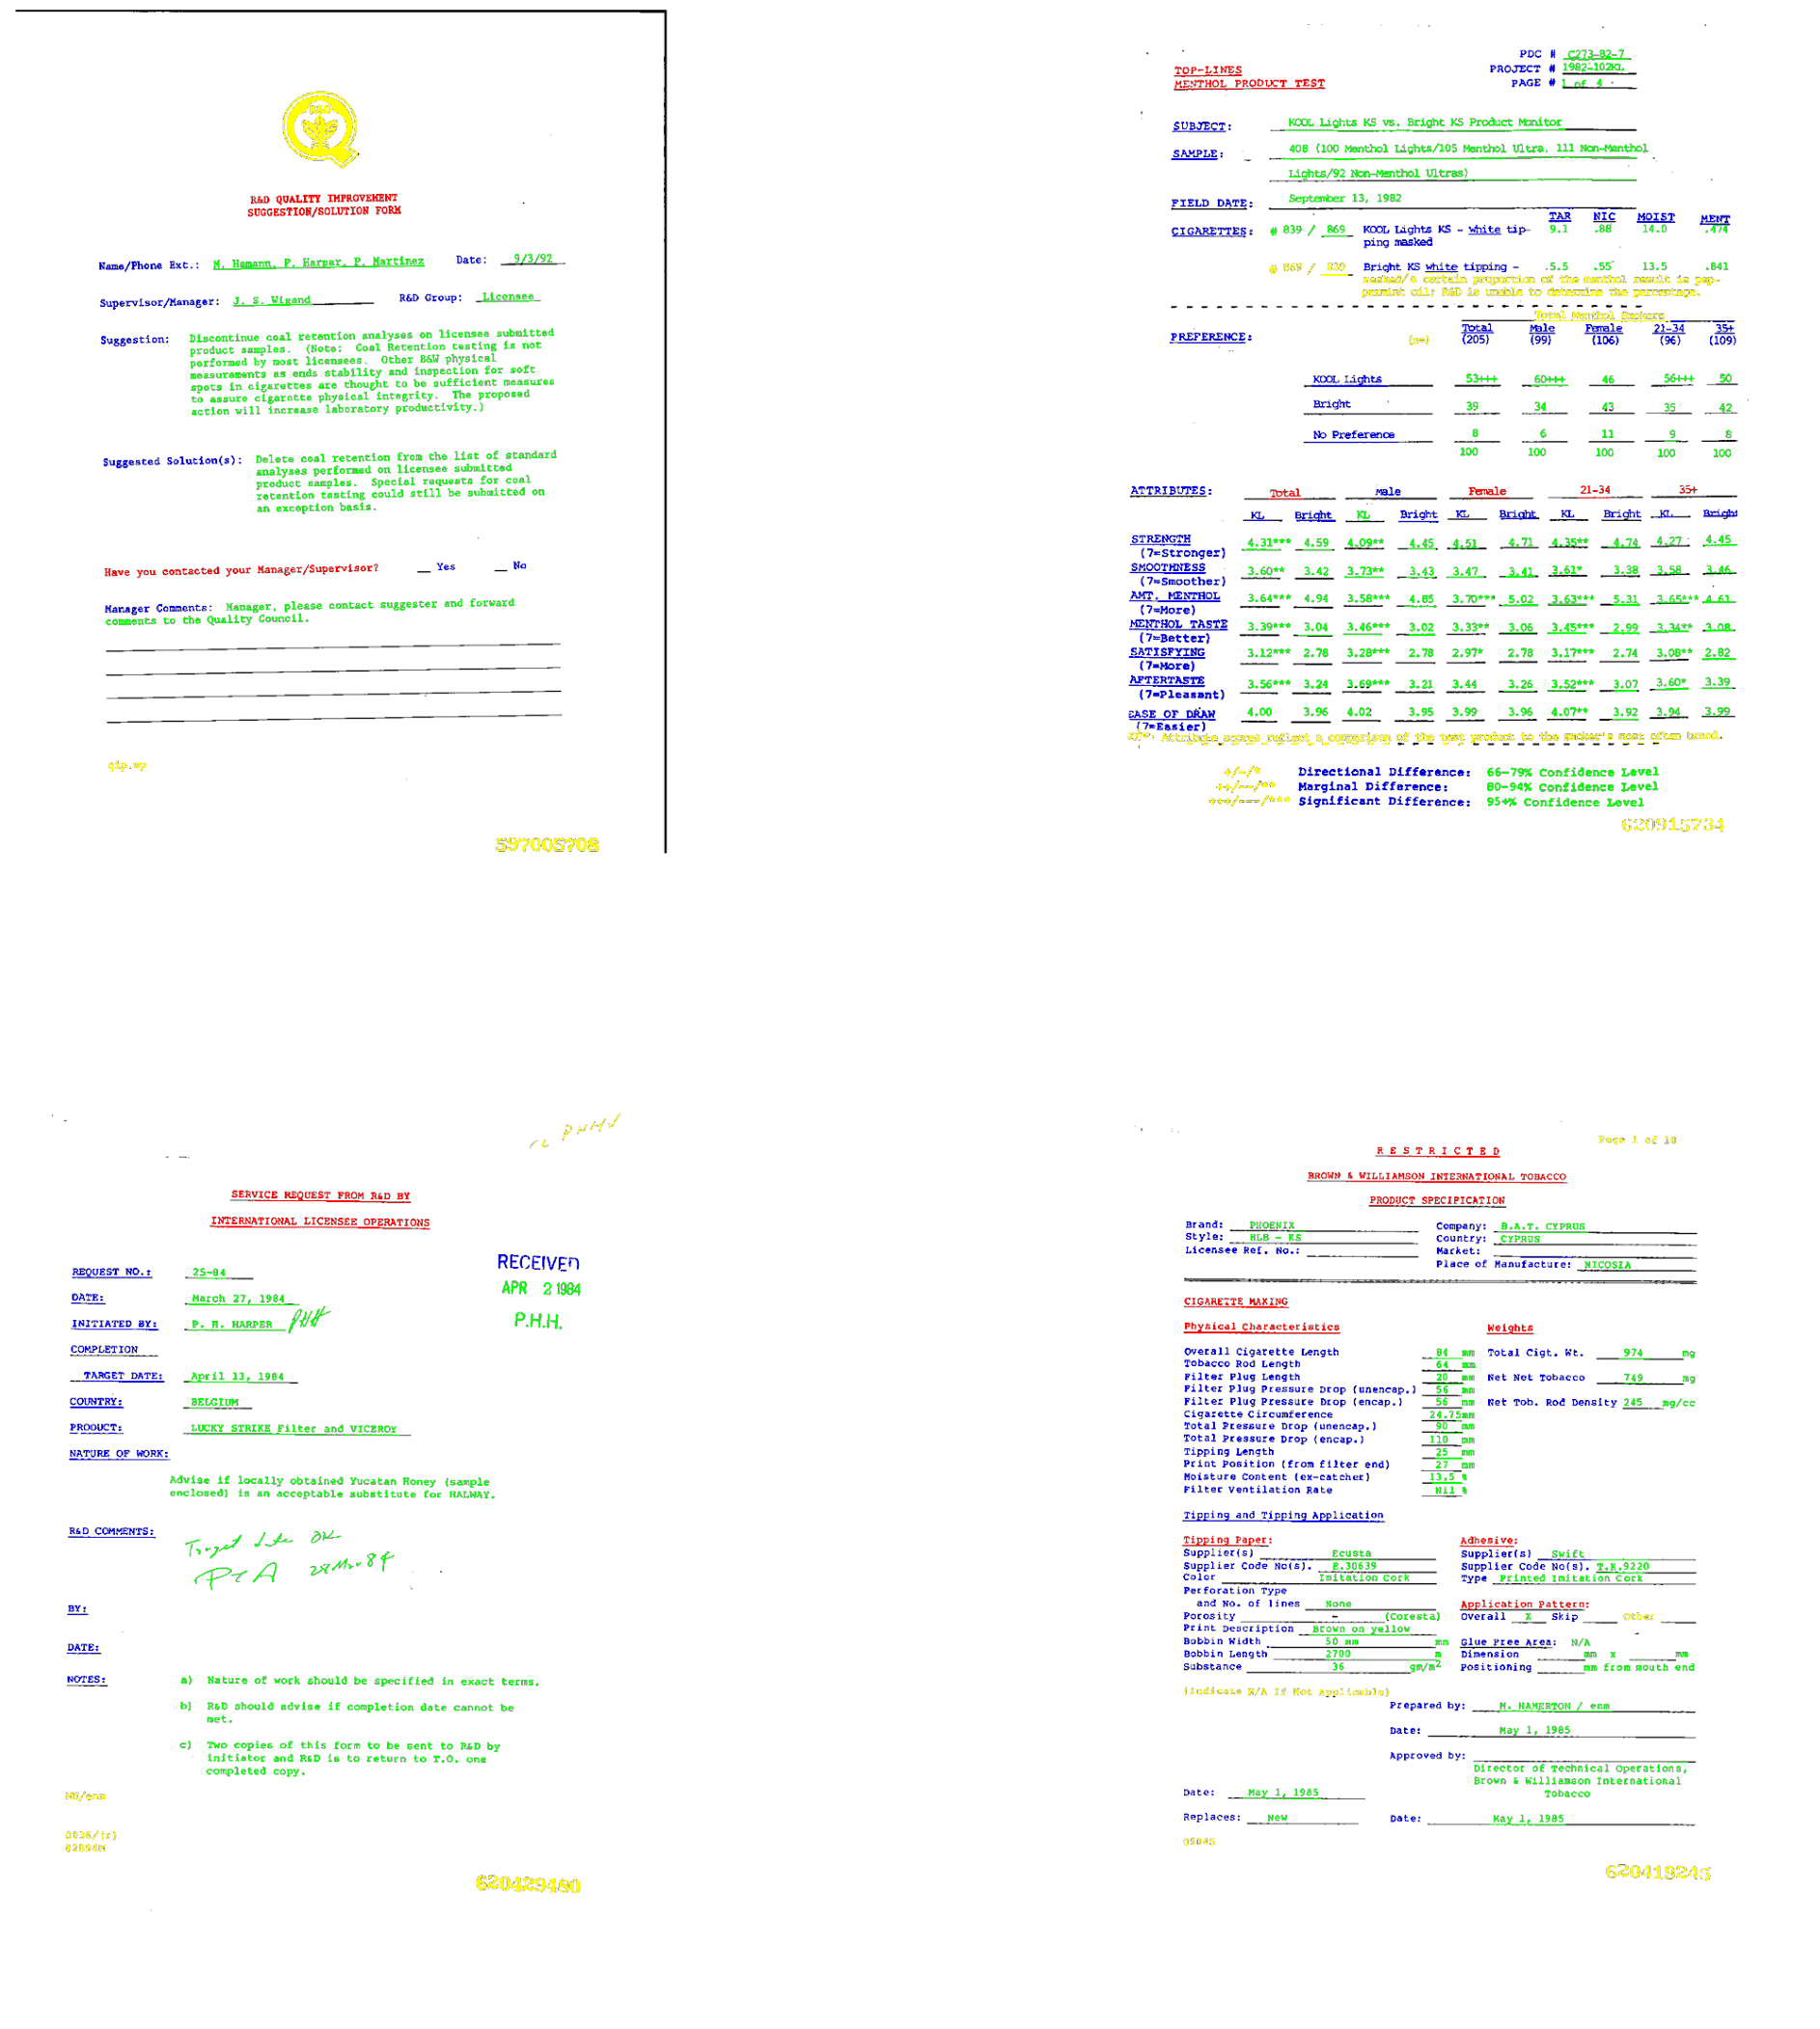

In [42]:
disp_multi_images(img_train_colored[:4])